In [2]:
import numpy as np
import os
import tensorflow
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [3]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "C:/Users/Sudeep Adhikari/Documents/Potato"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, 
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


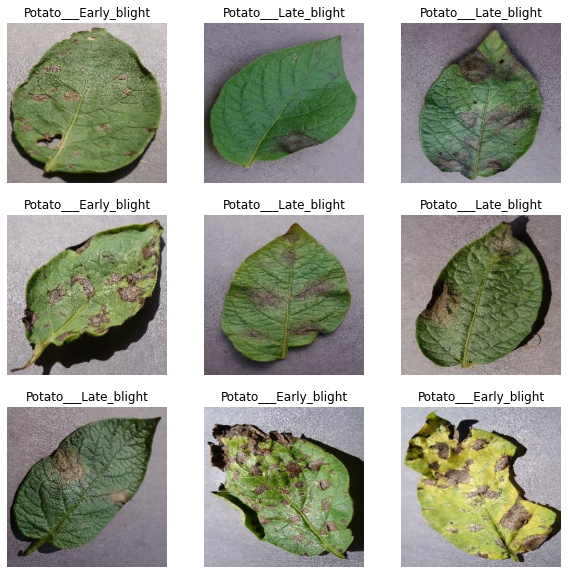

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [20]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [25]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 410s 6s/step - loss: 0.8774 - accuracy: 0.4971 - val_loss: 0.7609 - val_accuracy: 0.6562
Epoch 2/50
54/54 [==============================] - 259s 5s/step - loss: 0.5606 - accuracy: 0.7465 - val_loss: 0.5586 - val_accuracy: 0.7292
Epoch 3/50
54/54 [==============================] - 228s 4s/step - loss: 0.3221 - accuracy: 0.8680 - val_loss: 0.5273 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 218s 4s/step - loss: 0.2513 - accuracy: 0.9061 - val_loss: 0.3417 - val_accuracy: 0.8646
Epoch 5/50
54/54 [==============================] - 308s 6s/step - loss: 0.2570 - accuracy: 0.9067 - val_loss: 0.2468 - val_accuracy: 0.9010
Epoch 6/50
54/54 [==============================] - 306s 6s/step - loss: 0.2110 - accuracy: 0.9096 - val_loss: 0.2727 - val_accuracy: 0.8802
Epoch 7/50
54/54 [==============================] - 260s 5s/step - loss: 0.1824 - accuracy: 0.9284 - val_loss: 0.1910 - val_accuracy: 0.9167
Epoch 8/50
54

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import os
model_version = max([int(i) for i in (os.listdir("C:/Users/Sudeep Adhikari/Documents/models")+[0])]) + 1
model.save(f"C:/Users/Sudeep Adhikari/Documents/models{model_version}")

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")